In [1]:
import os
import json
import numpy as np
import matplotlib
from tqdm import tqdm
import matplotlib.pyplot as plt
from modules.vascular_data import contourToSeg
from medpy.metric.binary import dc, assd, hd
from modules.vascular_data import parse_xml_group
from modules.io import load_json, write_json

plt.style.use('seaborn-whitegrid')
matplotlib.rc('text', usetex=True)
matplotlib.rcParams.update({"font.size":16})

In [2]:
SPACING = 0.029
DIMS    = 160
R_SMALL = 0.4
DIMS_VEC = [DIMS, DIMS]
ORIGIN  = [0, 0]
SPACING_VEC = [SPACING, SPACING]

top_dir = "/home/marsdenlab/projects/SV/user_test_segreg"

before_json_dir = top_dir+"/json_before"
after_json_dir = top_dir+"/json_after"

xml_dirs_before = [
    top_dir+'/kdr/KDR33_project/Segmentations',
    top_dir+'/cabg6/cabg6_project/Segmentations',
    top_dir+'/pulmonary/SU0259_2011_NN/Segmentations',
]

xml_dirs_after = [
    top_dir+'/kdr/KDR33_noelia/Segmentations',
    top_dir+'/cabg6/cabg_6_new/Segmentations',
    top_dir+'/pulmonary/SU0259_2011_Melody/Segmentations',
]

codes = [
    "nn.kdr33",
    "nn.cabg6",
    "nn.pulmonary",
]

In [3]:
for i,X in enumerate(xml_dirs_before):
    input_files = os.listdir(X)
    input_files = [X+'/'+f for f in input_files]
    
    for f in input_files:
        contours = parse_xml_group(f)

        for c in contours:
            path = f.split('/')[-1].replace('.ctgr','')

            fn = before_json_dir+'/'+codes[i]+'.'+path+'.'+str(c['point_number'])+'.json'

            write_json(c,fn)
        
for i,X in enumerate(xml_dirs_after):
    input_files = os.listdir(X)
    input_files = [X+'/'+f for f in input_files]
    
    for f in input_files:
        contours = parse_xml_group(f)
        
        for c in contours:
            path = f.split('/')[-1].replace('.ctgr','')

            fn = after_json_dir+'/'+codes[i]+'.'+path+'.'+str(c['point_number'])+'.json'

            write_json(c,fn)

In [4]:
cases = [
    {"label":"nn",
     "pattern":"nn",
        "before_dir":before_json_dir,
        "after_dir":after_json_dir,
         "output_dir":top_dir+'/results/',
     "color":"#4878D0"
    }
]

In [5]:
for c in cases:
    print(c['label'])
    
    files = os.listdir(c['after_dir'])
    files = [f for f in files if c['pattern'] in f]
    c['dice'] = []
    c['dice_qc'] = []
    c['r_qc'] = []
    c['radius'] = []
    c['assd'] = []
    c['hd'] = []

    for bf in files:
        print(bf)
    #for bf in files:
        
        bf_full = c['before_dir'] + '/'+bf
        af_full = c['after_dir'] + '/'+bf
        
        if not os.path.exists(bf_full):
            continue
        else:
            bf_f = open(bf_full,'r')
            bf_j = json.load(bf_f)
            
            af_f = open(af_full, 'r')
            af_j = json.load(af_f)
    
            #plot_contours(bf_j, af_j, c['label'], c['output_dir'])
        
            seg_b = contourToSeg(np.array(bf_j['contour2D']), ORIGIN, DIMS_VEC, SPACING_VEC).astype(int)
            seg_a = contourToSeg(np.array(af_j['contour2D']), ORIGIN, DIMS_VEC, SPACING_VEC).astype(int)

            if np.sum(seg_b) <=0 or np.sum(seg_a) <= 0:
                continue
            
            r = np.sqrt(np.sum(seg_a))/np.pi*SPACING*2
            
            dice = dc(seg_b,seg_a)
            a_ = assd(seg_b,seg_a)*SPACING
            h_ = hd(seg_b,seg_a)*SPACING
            
            c['dice'].append(dice)
            c['radius'].append(r)
            c['assd'].append(a_)
            c['hd'].append(h_)    

    
    print(len(c['dice']))
    c['dice_mean'] = np.mean(c['dice'])
    c['dice_std' ] = np.std(c['dice'])
    c['dice_count'] = len(c['dice'])
    c['dice_mean_std'] = 2.0*c['dice_std']/np.sqrt(c['dice_count']-1)
    
    c['dice_small'] = [c['dice'][i] for i in range(len(c['dice'])) if c['radius'][i] < R_SMALL]
    c['dice_mean_small'] = np.mean(c['dice_small'])
    c['dice_std_small' ] = np.std(c['dice_small'])
    c['dice_count_small'] = len(c['dice_small'])
    c['dice_mean_std_small'] = 2.0*c['dice_std_small']/np.sqrt(c['dice_count_small']-1)
    
    c['dice_large'] = [c['dice'][i] for i in range(len(c['dice'])) if c['radius'][i] >= R_SMALL]
    c['dice_mean_large'] = np.mean(c['dice_large'])
    c['dice_std_large' ] = np.std(c['dice_large'])
    c['dice_count_large'] = len(c['dice_large'])
    c['dice_mean_std_large'] = 2.0*c['dice_std_large']/np.sqrt(c['dice_count_large']-1)
    
    #assd
    c['assd_mean'] = np.mean(c['assd'])
    c['assd_std' ] = np.std(c['assd'])
    c['assd_mean_std'] = 2.0*c['assd_std']/np.sqrt(c['dice_count']-1)
    
    c['assd_small'] = [c['assd'][i] for i in range(len(c['assd'])) if c['radius'][i] < R_SMALL]
    c['assd_mean_small'] = np.mean(c['assd_small'])
    c['assd_std_small' ] = np.std(c['assd_small'])
    c['assd_mean_std_small'] = 2.0*c['assd_std_small']/np.sqrt(c['dice_count_small']-1)
    
    c['assd_large'] = [c['assd'][i] for i in range(len(c['assd'])) if c['radius'][i] >= R_SMALL]
    c['assd_mean_large'] = np.mean(c['assd_large'])
    c['assd_std_large' ] = np.std(c['assd_large'])
    c['assd_mean_std_large'] = 2.0*c['assd_std_large']/np.sqrt(c['dice_count_large']-1)
    
    #assd
    c['hd_mean'] = np.mean(c['hd'])
    c['hd_std' ] = np.std(c['hd'])
    c['hd_mean_std'] = 2.0*c['hd_std']/np.sqrt(c['dice_count']-1)
    
    c['hd_small'] = [c['hd'][i] for i in range(len(c['hd'])) if c['radius'][i] < R_SMALL]
    c['hd_mean_small'] = np.mean(c['hd_small'])
    c['hd_std_small' ] = np.std(c['hd_small'])
    c['hd_mean_std_small'] = 2.0*c['hd_std_small']/np.sqrt(c['dice_count_small']-1)
    
    c['hd_large'] = [c['hd'][i] for i in range(len(c['hd'])) if c['radius'][i] >= R_SMALL]
    c['hd_mean_large'] = np.mean(c['hd_large'])
    c['hd_std_large' ] = np.std(c['hd_large'])
    c['hd_mean_std_large'] = 2.0*c['hd_std_large']/np.sqrt(c['dice_count_large']-1)

nn
nn.cabg6.rc1.50.json
nn.pulmonary.LPA.0.json
nn.pulmonary.RPA.140.json
nn.kdr33.brach1.70.json
nn.kdr33.rca.60.json
nn.pulmonary.LPA_01.90.json
nn.pulmonary.LPA_01.20.json
nn.pulmonary.LPA.180.json
nn.cabg6.aorta.80.json
nn.kdr33.lca.50.json
nn.kdr33.brach2.80.json
nn.kdr33.brach2.30.json
nn.pulmonary.RPA.217.json
nn.cabg6.aorta.50.json
nn.kdr33.lca.40.json
nn.kdr33.aorta.80.json
nn.kdr33.brach2.100.json
nn.pulmonary.RPA_01.50.json
nn.cabg6.graft_svg.90.json
nn.cabg6.rc1.110.json
nn.cabg6.lc1.50.json
nn.pulmonary.RPA_01.60.json
nn.pulmonary.RPA.30.json
nn.kdr33.lca.70.json
nn.cabg6.graft_svg.50.json
nn.pulmonary.LPA_02.70.json
nn.kdr33.brach3.0.json
nn.pulmonary.LPA_02.90.json
nn.kdr33.brach1.90.json
nn.cabg6.ao_br2.30.json
nn.pulmonary.RPA.190.json
nn.kdr33.brach1.20.json
nn.cabg6.graft_svg.20.json
nn.kdr33.aorta.70.json
nn.pulmonary.LPA.196.json
nn.cabg6.ao_br3.70.json
nn.kdr33.rca.50.json
nn.pulmonary.LPA_02.20.json
nn.cabg6.ao_br2.50.json
nn.pulmonary.LPA_02.60.json
nn.cabg6.ao_

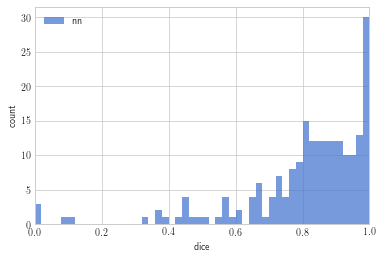

In [6]:
plt.figure()

plt.hist(cases[0]['dice'], bins=50, alpha=0.75, color=cases[0]['color'], 
         label=cases[0]['label'])

plt.xlabel('dice')
plt.ylabel('count')
plt.xlim([0,1])
plt.legend()
plt.savefig(cases[0]['output_dir']+'dice_hist_nn_multiscale.pdf',
            bbox_inches='tight',dpi=500)
plt.show()
plt.close()

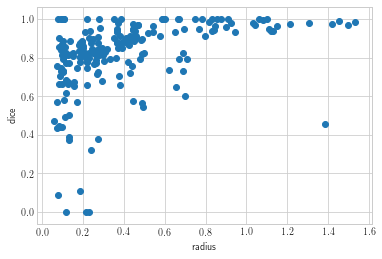

In [16]:
plt.figure()

plt.scatter(cases[0]['radius'], cases[0]['dice'])

plt.xlabel('radius')
plt.ylabel('dice')
plt.savefig(cases[0]['output_dir']+'dice_scatter_nn_multiscale.pdf',
            bbox_inches='tight',dpi=500)
plt.show()
plt.close()

In [7]:
for c in cases:
    print(c['label'])
    print("number contours: {}".format(len(c['dice'])))
    print("Dice, mean = {}, std = {}".format(c['dice_mean'], c['dice_mean_std']))
    print("")

nn
number contours: 206
Dice, mean = 0.8119146391922095, std = 0.02668370746804611



In [8]:
for c in cases:
    print(c['label'])
    print("number contours: {}".format(c['dice_count_small']))
    print("Dice, mean = {}, std = {}".format(c['dice_mean_small'], c['dice_mean_std_small']))
    print("")

nn
number contours: 127
Dice, mean = 0.7575838856859435, std = 0.03678078353158568



In [9]:
for c in cases:
    print(c['label'])
    print("number contours: {}".format(c['dice_count_large']))
    print("Dice, mean = {}, std = {}".format(c['dice_mean_large'], c['dice_mean_std_large']))
    print("")

nn
number contours: 79
Dice, mean = 0.89925648343646, std = 0.027055323793023122



IndexError: list index out of range

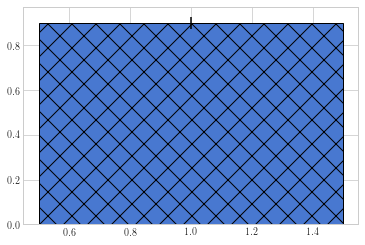

In [10]:
plt.figure()
plt.bar(1, height=cases[0]['dice_mean_large'], width=1, 
        color=cases[0]['color'], label=cases[0]['label'], 
        yerr=cases[0]['dice_mean_std_large'], hatch='x',edgecolor='k')

plt.bar(3, height=cases[1]['dice_mean_large'], width=1, 
        color=cases[1]['color'], label=cases[1]['label'], 
        yerr=cases[1]['dice_mean_std_large'], hatch='x',edgecolor='k')

plt.bar(5, height=cases[2]['dice_mean_large'], width=1, 
        color=cases[2]['color'], label=cases[2]['label'], 
        yerr=cases[2]['dice_mean_std_large'], hatch='x',edgecolor='k')

#lgd = plt.legend(loc=(1.02,0))
plt.ylabel('average dice')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
plt.tight_layout()
plt.ylim(0,1)
plt.title(r"$r > 0.55$")
plt.savefig(cases[0]['output_dir']+'dice_bar_large.pdf', 
            bbox_inches='tight',dpi=500)

plt.show()
plt.close()

In [ ]:
plt.figure()
plt.bar(1, height=cases[0]['dice_mean_small'], width=1, 
        color=cases[0]['color'], label=cases[0]['label'], 
        yerr=cases[0]['dice_mean_std_small'], hatch='x',edgecolor='k')

plt.bar(3, height=cases[1]['dice_mean_small'], width=1, 
        color=cases[1]['color'], label=cases[1]['label'], 
        yerr=cases[1]['dice_mean_std_small'], hatch='x',edgecolor='k')

plt.bar(5, height=cases[2]['dice_mean_small'], width=1, 
        color=cases[2]['color'], label=cases[2]['label'], 
        yerr=cases[2]['dice_mean_std_small'], hatch='x',edgecolor='k')

#lgd = plt.legend(loc=(1.02,0))
plt.ylabel('average dice')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
plt.tight_layout()
plt.ylim(0,1)
plt.title(r"$r \leq 0.55$")
plt.savefig(cases[0]['output_dir']+'dice_bar_small.pdf', 
            bbox_inches='tight',dpi=500)

plt.show()
plt.close()

In [ ]:
plt.figure()
plt.bar(1, height=cases[0]['dice_mean'], width=1, 
        color=cases[0]['color'], label=cases[0]['label'], 
        yerr=cases[0]['dice_mean_std'], hatch='x',edgecolor='k')

plt.bar(3, height=cases[1]['dice_mean'], width=1, 
        color=cases[1]['color'], label=cases[1]['label'], 
        yerr=cases[1]['dice_mean_std'], hatch='x',edgecolor='k')

plt.bar(5, height=cases[2]['dice_mean'], width=1, 
        color=cases[2]['color'], label=cases[2]['label'], 
        yerr=cases[2]['dice_mean_std'], hatch='x',edgecolor='k')

lgd = plt.legend(bbox_to_anchor=(0., 1.01, 1., .101), loc=3,
           ncol=2)

plt.ylabel('average dice')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
plt.tight_layout()
plt.ylim(0,1)
plt.savefig(cases[0]['output_dir']+'dice_bar.pdf', bbox_extra_artists=(lgd,), 
            bbox_inches='tight',dpi=500)

plt.show()
plt.close()



In [ ]:
plt.figure()
plt.scatter(cases[0]['radius'], cases[0]['dice'], alpha=0.75, 
            color=cases[0]['color'], label=cases[0]['label'])

plt.legend()
plt.xlabel('radius')
plt.ylabel('dice')

plt.ylim([0,1.1])
plt.legend()
plt.savefig(cases[0]['output_dir']+'dice_scatter_nn.pdf',
            bbox_inches='tight',dpi=500)
plt.show()
plt.close()

In [ ]:
plt.figure()
plt.scatter(cases[1]['radius'], cases[1]['dice'], alpha=0.75, 
            color=cases[1]['color'], label=cases[1]['label'])

plt.legend()
plt.xlabel('radius')
plt.ylabel('dice')

plt.ylim([0,1.1])
plt.legend()
plt.savefig(cases[0]['output_dir']+'dice_scatter_threshold.pdf',
            bbox_inches='tight',dpi=500)
plt.show()
plt.close()

In [ ]:
plt.figure()
plt.scatter(cases[2]['radius'], cases[2]['dice'], alpha=0.75, 
            color=cases[2]['color'], label=cases[2]['label'])

plt.legend()
plt.xlabel('radius')
plt.ylabel('dice')

plt.ylim([0,1.1])
plt.legend()
plt.savefig(cases[0]['output_dir']+'dice_scatter_drls.pdf',
            bbox_inches='tight',dpi=500)
plt.show()
plt.close()

In [11]:
for c in cases:
    
    dice_mean = c['dice_mean']
    dice_std  = c['dice_mean_std']
    
    dice_mean_l = c['dice_mean_large']
    dice_std_l  = c['dice_mean_std_large']
    
    dice_mean_s = c['dice_mean_small']
    dice_std_s  = c['dice_mean_std_small']
    
    #Hausdorf
    hd_mean = c['hd_mean']
    hd_std  = c['hd_mean_std']
    
    hd_mean_l = c['hd_mean_large']
    hd_std_l  = c['hd_mean_std_large']
    
    hd_mean_s = c['hd_mean_small']
    hd_std_s  = c['hd_mean_std_small']
    
    #ASSD
    assd_mean = c['assd_mean']
    assd_std  = c['assd_mean_std']
    
    assd_mean_l = c['assd_mean_large']
    assd_std_l  = c['assd_mean_std_large']
    
    assd_mean_s = c['assd_mean_small']
    assd_std_s  = c['assd_mean_std_small']
    
    print("{} & ${:.3f} $ & ${:.3f} $ & ${:.3f} $\
    & ${:.3f} $ & ${:.3f} $ & ${:.3f} $\
    & ${:.3f} $ & ${:.3f} $ & ${:.3f} $\\".format(
    c['label'], dice_mean, dice_mean_l, dice_mean_s,
    hd_mean, hd_mean_l, hd_mean_s,
    assd_mean, assd_mean_l, assd_mean_s))

nn & $0.812 $ & $0.899 $ & $0.758 $    & $0.099 $ & $0.116 $ & $0.089 $    & $0.046 $ & $0.053 $ & $0.042 $\


In [15]:
for c in cases:
    dice_accept = [d for d in c['dice'] if d > 0.805]
    p           = (1.0*len(dice_accept))/(len(c['dice']))
    p_std       = 3*(p)*(1.0-p)/np.sqrt(len(c['dice'])-1)
    
    dice_accept_s = [d for d in c['dice_small'] if d > 0.782]
    p_s           = (1.0*len(dice_accept_s))/(len(c['dice_small']))
    p_s_std       = 3*(p_s)*(1.0-p_s)/np.sqrt(len(c['dice_small'])-1)
    
    dice_accept_l = [d for d in c['dice_large'] if d > 0.928]
    p_l           = (1.0*len(dice_accept_l))/(len(c['dice_large']))
    p_l_std       = 3*(p_l)*(1.0-p_l)/np.sqrt(len(c['dice_large'])-1)
    
    p = (len(dice_accept_l)+len(dice_accept_s))/(len(c['dice']))
    
    print("{} & ${:.2f} $ & ${:.2f} $ & ${:.2f} $"\
    .format(c['label'], p, p_l, p_s))

nn & $0.60 $ & $0.57 $ & $0.61 $


In [13]:
for c in cases:
    dice_accept = [d for d in c['dice'] if d > 0.935]
    p           = (1.0*len(dice_accept))/(len(c['dice']))
    p_std       = 3*(p)*(1.0-p)/np.sqrt(len(c['dice'])-1)
    
    dice_accept_s = [d for d in c['dice_small'] if d > 0.935]
    p_s           = (1.0*len(dice_accept_s))/(len(c['dice_small']))
    p_s_std       = 3*(p_s)*(1.0-p_s)/np.sqrt(len(c['dice_small'])-1)
    
    dice_accept_l = [d for d in c['dice_large'] if d > 0.935]
    p_l           = (1.0*len(dice_accept_l))/(len(c['dice_large']))
    p_l_std       = 3*(p_l)*(1.0-p_l)/np.sqrt(len(c['dice_large'])-1)
    
    print("{} & ${:.2f} $ & ${:.2f} $ & ${:.2f} $"\
    .format(c['label'], p, p_l, p_s))

nn & $0.28 $ & $0.63 $ & $0.13 $


In [ ]:
print(len(cases[0]['dice_qc']), len(cases[0]['dice']))
print(len(cases[1]['dice_qc']), len(cases[1]['dice']))
print(len(cases[2]['dice_qc']), len(cases[2]['dice']))